In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import glob
import warnings

warnings.filterwarnings('ignore')

sns.set(rc={"figure.dpi":1200})
sns.set_context('notebook')
sns.set_style("ticks")

mpl.style.use('default')

# Update rcParams for global consistency
mpl.rcParams.update({
    'axes.linewidth': 7,           # Line width for axes
    'xtick.major.size': 20,        # Major tick size
    'xtick.major.width': 7,        # Major tick width
    'xtick.minor.size': 10,        # Minor tick size
    'xtick.minor.width': 7,        # Minor tick width
    'ytick.major.size': 20,        # Major tick size
    'ytick.major.width': 7,        # Major tick width
    'ytick.minor.size': 10,        # Minor tick size
    'ytick.minor.width': 7,        # Minor tick width
    'ytick.labelsize': 60,         # Label size for y ticks
    'xtick.labelsize': 60,         # Label size for x ticks
    'font.size': 60,               # Font size for text
    'font.sans-serif': 'Arial',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Arial',
    'mathtext.it': 'Arial',
    'mathtext.bf': 'Arial:bold',
    'lines.linewidth': 7,          # Line width for all lines
    'scatter.marker': 'o',         # Default marker for scatter
    'lines.markersize': 10,        # Marker size for scatter in points
    'axes.titlesize': 'large',     # Title size
    'axes.labelsize': 'large',     # Label size for axes
    'legend.fontsize': 'large'     # Font size for legends
})


In [2]:
###import dataframe and count the length of each amino acid sequence
###make sure to change the appropriate sequence 
df = pd.read_csv('STALLER_2022_wREE (1).csv')
df['activity']=df['Activity_Mean_MSS18']-2000
# Filter out rows where 'activity' column has negative values
df = df[df['activity'] >= 0]

In [3]:
# Adjust pandas display settings to show all columns
# Filter the DataFrame for the specific conditions
filtered_row = df[(df['WT'] == True) & (df['CITED2'] == True)]

# Check if the filtered row exists and print the entire row
if not filtered_row.empty:
    print("Row where 'Variant_Name' is 'killmotif1' and 'CITED2' is True:")
    print(filtered_row.to_string(index=False))
else:
    print("No matching row found.")

filtered_row

Row where 'Variant_Name' is 'killmotif1' and 'CITED2' is True:
 Index                                   ADseq Variant_Name SystematicName  Activity_Mean_MSS18  Activity_std_MSS18  Biological_Replicate_1_Activity  Biological_Replicate_2_Activity  Biological_Replicate_3_Activity  Biological_Replicate_4_Activity  8_Bin_sort   WT HandDesigned PerturbCharge PerturbAromatics CITED2 Stat3 Hif1alpha p65_L2Y   p65 VP16 H1 CorrectedPvalues_FDR_5percent SigDiffFromWT  ree (nm)    activity
 480.0 TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTD         none            NaN          4633.448213          835.652083                      4570.438177                      4006.139318                      3757.467766                      4190.845415 5727.511821 True        False         False            False   True False     False   False False   False                             1         FALSE  4.545165 2633.448213


,Index,ADseq,Variant_Name,SystematicName,Activity_Mean_MSS18,Activity_std_MSS18,Biological_Replicate_1_Activity,Biological_Replicate_2_Activity,Biological_Replicate_3_Activity,Biological_Replicate_4_Activity,...,CITED2,Stat3,Hif1alpha,p65_L2Y,p65,VP16 H1,CorrectedPvalues_FDR_5percent,SigDiffFromWT,ree (nm),activity
480,480.0,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTD,none,NaN,4633.448213,835.652083,4570.438177,4006.139318,3757.467766,4190.845415,...,True,False,False,False,False,False,1,FALSE,4.545165,2633.448213


In [4]:
# Use a case-insensitive regex search to find 'Shuffle' variations and remove those rows
pattern = r'shuffle'  # Pattern to search for any variation of 'Shuffle'
df = df[~df['Variant_Name'].str.contains(pattern, case=False, na=False)]
# Convert to float first
df['CorrectedPvalues_FDR_5percent'] = pd.to_numeric(df['CorrectedPvalues_FDR_5percent'], errors='coerce')
###CONVERT P-VALUES####
df['-log10_p-values'] = -np.log10(df['CorrectedPvalues_FDR_5percent'])

In [5]:
###NORMALIZE +LOG2 FC ACTIVITY###
# List of columns to use for normalization condition
columns = ['CITED2', 'Stat3', 'Hif1alpha', 'p65', 'VP16 H1']

# Initialize the new column with NaN or a default value
df['normalized_activity'] = np.nan

# Loop through each specified column to calculate the normalized_activity
for col in columns:
    # Find the 'activity' value for the reference row where both the specific column and 'WT' are True
    reference_activity = df.loc[(df[col] == True) & (df['WT'] == True), 'activity'].values[0]
    
    # Calculate normalized_activity for rows where the specific column is True
    df.loc[df[col] == True, 'normalized_activity'] = df['activity'] / reference_activity

df[['CITED2', 'Stat3', 'Hif1alpha', 'p65_L2Y', 'p65', 'VP16 H1', 'WT', 'activity', 'normalized_activity']]

####FC OF NORMALIZED ACTIVITY
df['log2_FC'] = np.log2(df['normalized_activity'])
# Define a function to assign colors based on conditions
def assign_color(row):
    if row['Hif1alpha'] == True and (row['log2_FC'] > 1 and row['-log10_p-values'] > 1.30102999566):
        return 'indigo'
    elif row['Hif1alpha'] == True and (row['log2_FC'] < -1 and row['-log10_p-values'] > 1.30102999566):
        return 'violet'
    elif row['CITED2'] == True and (row['log2_FC'] < -1 and row['-log10_p-values'] > 1.30102999566):
        return 'lightgreen'
    else:
        return (0.5, 0.5, 0.5, 0.5)  # Grey with transparency

# Apply the function to create a new 'color' column
df['color'] = df.apply(assign_color, axis=1)


In [6]:
# Define the colors to filter by
colors = ['indigo', 'thistle', 'lightgreen']

# Filter for rows where 'Hif1alpha' is True and 'color' matches the specified colors
hif1alpha_df = df[(df['Hif1alpha'] == True) & (df['color'].isin(colors))]

# Filter for rows where 'CITED2' is True and 'color' matches the specified colors
cited2_df = df[(df['CITED2'] == True) & (df['color'].isin(colors))]

# Print the 'Variant_Name' values of the filtered DataFrames
print("Hif1alpha Variants:")
print(hif1alpha_df['Variant_Name'].values)

print("\nCITED2 Variants:")
print(cited2_df['Variant_Name'].values)


Hif1alpha Variants:
['RK>D' 'supercharge6' 'QN>Emut7to29' 'Y>W' 'RK>Amut29to46'
 'RK>Dmut29to46' 'QN>Dmut29to46' 'QN>Emut29to46']

CITED2 Variants:
['STQN>K' 'STQN>R' 'EDKR>A' 'EDKR>Amut0to20' 'ED>A' 'IVL>F' 'L>F'
 'EDKR>Amut20to39' 'ED>Amut20to39' 'kilmotif2_LPEL_A' 'killmotif3'
 'kilmotif2_LPEL_G' 'NQ>F' 'STQN>Kmut20to39' 'QN>K' 'STQN>Rmut20to39'
 'QN>R' 'NQ>W' 'ED>Kmut20to39' 'ED>Rmut20to39' 'L>W' 'L>Y' 'breakhelixP'
 'I>W' 'IVL>W' 'IVL>Y' 'ED>Emut0to20' 'ED>E' 'ED>Kmut0to20' 'ED>K'
 'ED>Rmut0to20' 'ED>R']


In [7]:
# Filter the DataFrame for the specific conditions
filtered_row = df[(df['Hif1alpha'] == True) & (df['Variant_Name'] == 'NQ>W')]

# Check if the filtered row exists and print the 'log2_FC', '-log10_p-values', and 'SigDiffFromWT' values
if not filtered_row.empty:
    log2_fc_value = filtered_row['log2_FC'].iloc[0]
    log10_p_value = filtered_row['-log10_p-values'].iloc[0]
    sig_diff_from_wt = filtered_row['SigDiffFromWT'].iloc[0]
    print("log2_FC value for 'NQ>W' where 'Hif1alpha' is True:", log2_fc_value)
    print("-log10_p-values value for 'NQ>W' where 'Hif1alpha' is True:", log10_p_value)
    print("SigDiffFromWT value for 'NQ>W' where 'Hif1alpha' is True:", sig_diff_from_wt)
else:
    print("No matching row found.")


log2_FC value for 'NQ>W' where 'Hif1alpha' is True: -2.754448198942854
-log10_p-values value for 'NQ>W' where 'Hif1alpha' is True: 1.0753880890529655
SigDiffFromWT value for 'NQ>W' where 'Hif1alpha' is True: FALSE


In [8]:
import pandas as pd

# Filter the DataFrame for the specific conditions
filtered_rows_hif1alpha = df[(df['Hif1alpha'] == True) & (df['Variant_Name'] == 'NQ>W')]
filtered_rows_cited2 = df[(df['CITED2'] == True) & (df['Variant_Name'].isin(['killmotif1', 'RK>E', 'RK>Amut20to39']))]

# Concatenate the filtered rows into a single DataFrame
filtered_rows = pd.concat([filtered_rows_hif1alpha, filtered_rows_cited2])

# Check if the filtered rows exist and create a new DataFrame with the results
if not filtered_rows.empty:
    result_df = filtered_rows[['Variant_Name', 'log2_FC', '-log10_p-values', 'SigDiffFromWT', 'Hif1alpha', 'CITED2']]
    print("Results DataFrame:")
    print(result_df)
else:
    print("No matching rows found.")
    result_df = pd.DataFrame()  # Create an empty DataFrame if no matching row is found

# Return the result DataFrame
result_df

Results DataFrame:
      Variant_Name   log2_FC  -log10_p-values SigDiffFromWT Hif1alpha CITED2
317           NQ>W -2.754448         1.075388         FALSE      True  False
448           RK>E  0.233740         2.267303         FALSE     False   True
453  RK>Amut20to39  0.474522         0.863403         FALSE     False   True


,Variant_Name,log2_FC,-log10_p-values,SigDiffFromWT,Hif1alpha,CITED2
317,NQ>W,-2.754448,1.075388,FALSE,True,False
448,RK>E,0.233740,2.267303,FALSE,False,True
453,RK>Amut20to39,0.474522,0.863403,FALSE,False,True


In [9]:
print(df.columns)

Index(['Index', 'ADseq', 'Variant_Name', 'SystematicName',
       'Activity_Mean_MSS18', 'Activity_std_MSS18',
       'Biological_Replicate_1_Activity', 'Biological_Replicate_2_Activity',
       'Biological_Replicate_3_Activity', 'Biological_Replicate_4_Activity',
       '8_Bin_sort', 'WT', 'HandDesigned', 'PerturbCharge', 'PerturbAromatics',
       'CITED2', 'Stat3', 'Hif1alpha', 'p65_L2Y', 'p65', 'VP16 H1',
       'CorrectedPvalues_FDR_5percent', 'SigDiffFromWT', 'ree (nm)',
       'activity', '-log10_p-values', 'normalized_activity', 'log2_FC',
       'color'],
      dtype='object')


In [10]:
###NORMALIZE +LOG2 RE###
# List of columns to use for normalization condition
columns = ['CITED2', 'Stat3', 'Hif1alpha', 'p65', 'VP16 H1']

# Initialize the new column with NaN or a default value
df['Re_normalized'] = np.nan

# Loop through each specified column to calculate the normalized_activity
for col in columns:
    # Find the 'activity' value for the reference row where both the specific column and 'WT' are True
    reference_r_e = df.loc[(df[col] == True) & (df['WT'] == True), 'ree (nm)'].values[0]
    
    # Calculate normalized_activity for rows where the specific column is True
    df.loc[df[col] == True, 'Re_normalized'] = df['ree (nm)'] / reference_r_e

df[['CITED2', 'Stat3', 'Hif1alpha', 'p65_L2Y', 'p65', 'VP16 H1', 'WT', 'activity', 'Re_normalized','color']]
# Assuming your DataFrame is named 'df'
#df.to_csv('/Users/eflores500/Documents/STALLER_MANUSCRIPT/FIGURES/SIFNIFCANT_ACTIVITY_VS_SEQ_FEATURES/Re_normalized.csv', index=False)


,CITED2,Stat3,Hif1alpha,p65_L2Y,p65,VP16 H1,WT,activity,Re_normalized,color
0,False,False,True,False,False,False,False,123.985450,1.004956,"(0.5, 0.5, 0.5, 0.5)"
1,False,False,True,False,False,False,False,1614.586555,1.031064,"(0.5, 0.5, 0.5, 0.5)"
2,False,True,False,False,False,False,False,621.306903,1.209026,"(0.5, 0.5, 0.5, 0.5)"
3,False,True,False,False,False,False,False,734.312216,1.118262,"(0.5, 0.5, 0.5, 0.5)"
4,True,False,False,False,False,False,False,2934.729353,1.065642,"(0.5, 0.5, 0.5, 0.5)"
...,...,...,...,...,...,...,...,...,...,...
520,True,False,False,False,False,False,False,546.054013,0.922409,lightgreen
521,True,False,False,False,False,False,False,371.893236,1.088280,lightgreen
522,True,False,False,False,False,False,False,327.564901,0.860556,lightgreen
523,True,False,False,False,False,False,False,449.439861,1.033596,lightgreen


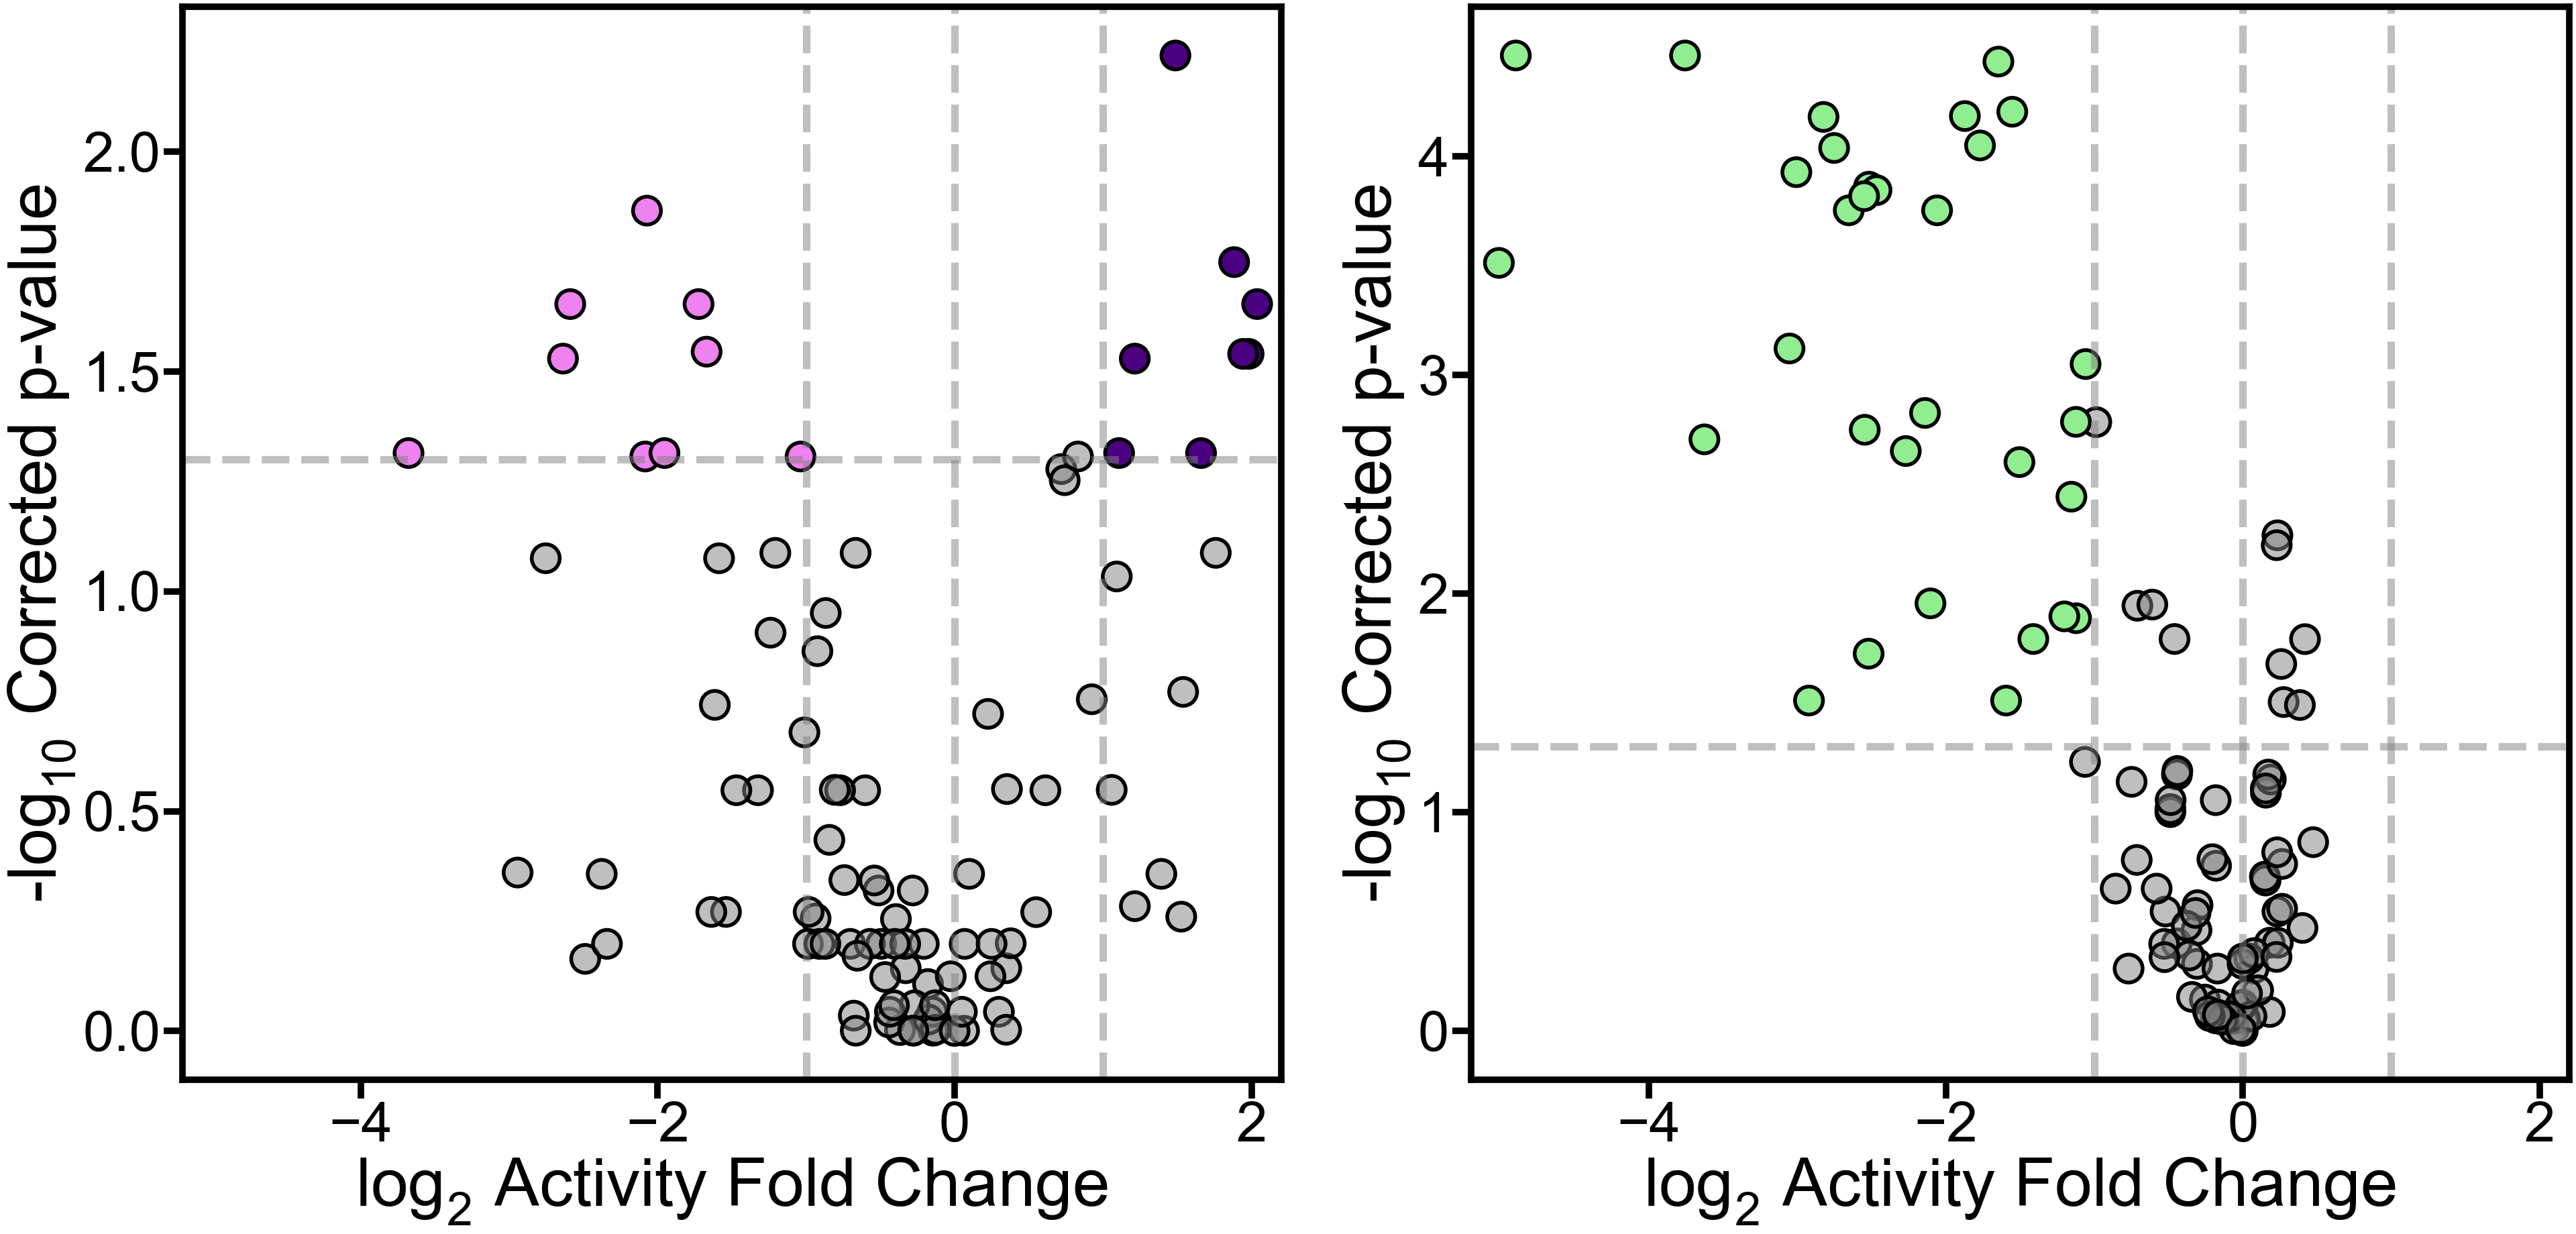

In [11]:
from matplotlib.colors import TwoSlopeNorm

# List of variant columns to plot
variants = ['Hif1alpha', 'CITED2']

# Determine the layout of the subplots
n_rows = 1
n_cols = 2

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(40, 20), sharex=True, sharey=False)
# Flatten the axes array for easy iteration if it's multidimensional
axes = axes.flatten()

# Loop through each variant and plot it in a separate subplot as a volcano plot
for i, variant in enumerate(variants):
    # Filter df for rows where the variant column is True
    subset_df = df[df[variant] == True]

    # Volcano plot for the variant: log2_FC on x-axis and --log10_p-values on y-axis
    
    scatter = axes[i].scatter(subset_df['log2_FC'], subset_df['-log10_p-values'],color=subset_df['color'], s=900, edgecolors='black', linewidths=4)
    
    axes[i].set_xlabel(r'log$_2$ Activity Fold Change')
    axes[i].set_ylabel(r'-log$_{10}$ Corrected p-value')

    # Setting xlim to start at -5

    # Adding vertical and horizontal dashed lines
    axes[i].axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=8)
    axes[i].axvline(x=1, color='gray', linestyle='--', alpha=0.5, linewidth=8)
    axes[i].axvline(x=-1, color='gray', linestyle='--', alpha=0.5, linewidth=8)
    axes[i].axhline(y=1.3, color='gray', linestyle='--', alpha=0.5, linewidth=8)
    axes[i].set_xlim(-5.2, 2.2)
# Hide any unused subplot areas (if the number of variants is odd)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout for better visualization
plt.tight_layout()

plt.show()
